In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import GroupKFold,StratifiedKFold
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')
sbn.set(style='white')

In [2]:
train_data = pd.read_csv('../input/train.csv')
train_data.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [3]:
test_data = pd.read_csv('../input/test.csv')
test_data.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [4]:
structure_data = pd.read_csv('../input/structures.csv')
structure_data.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [5]:
print("Missing values in training file:\n ", train_data.isnull().sum())
print("Missing values in Structures file:\n ", structure_data.isnull().sum())

Missing values in training file:
  id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
dtype: int64
Missing values in Structures file:
  molecule_name    0
atom_index       0
atom             0
x                0
y                0
z                0
dtype: int64


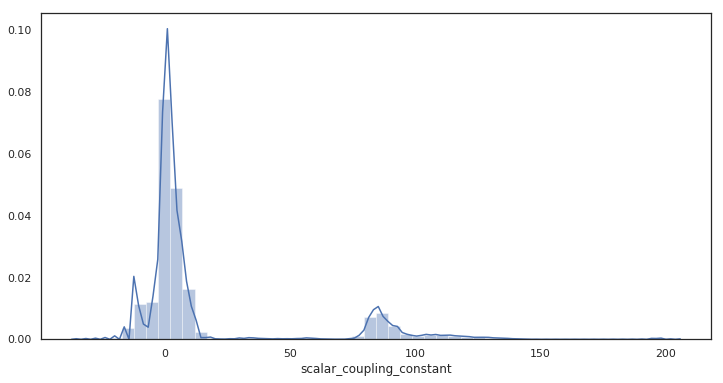

In [6]:
plt.figure(figsize = (12, 6))
sbn.distplot(train_data['scalar_coupling_constant'])
plt.show()

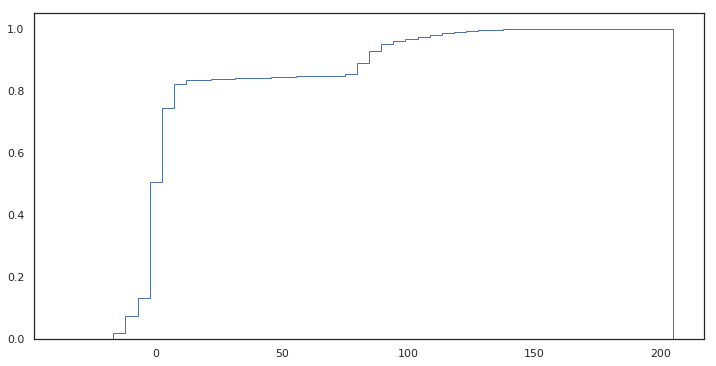

In [7]:
x = train_data['scalar_coupling_constant']

fig, ax = plt.subplots(figsize=(12, 6))
n_bins = 50

# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, normed=1, histtype='step',
                           cumulative=True, label='Empirical')

In [8]:
indices = [index for index, row in train_data.iterrows() 
           if row['scalar_coupling_constant']>160]
print("Before deletion: ", train_data.shape)
train_data.drop(train_data.index[indices], axis=0, inplace=True)
print("After deletion: ", train_data.shape)

Before deletion:  (4658147, 6)
After deletion:  (4648878, 6)


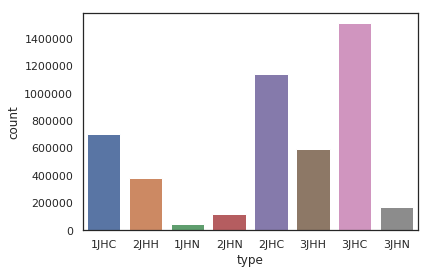

In [9]:
sbn.countplot(x='type', data=train_data)

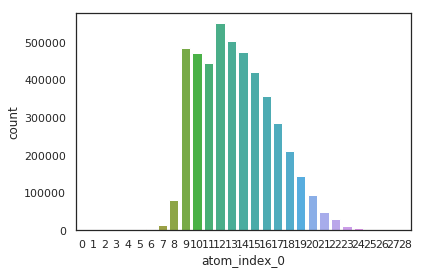

In [10]:
sbn.countplot(x='atom_index_0', data=train_data)

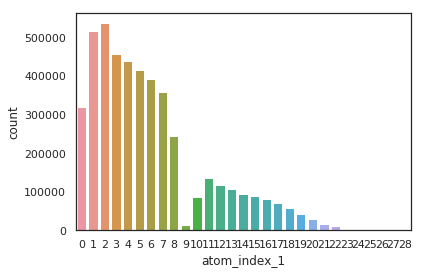

In [11]:
sbn.countplot(x='atom_index_1', data=train_data)

In [12]:
cross_index = ['atom_index_0','atom_index_1']

cm = sbn.light_palette("green", as_cmap=True)
pd.crosstab(train_data[cross_index[0]], train_data[cross_index[1]]).style.background_gradient(cmap = cm)

atom_index_1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
atom_index_0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,37,0,38,37,33,24,1,8,8,5,4,1,21,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,86,49,0,86,82,64,12,18,13,16,29,42,61,40,26,16,5,5,0,0,0,0,0,0,0,0,0,0,0
3,127,104,77,0,129,128,33,21,14,17,4,24,55,37,30,19,7,3,0,0,0,0,0,0,0,0,0,0,0
4,78,113,108,42,0,112,65,31,11,11,1,3,4,7,17,17,11,3,0,0,0,0,0,0,0,0,0,0,0
5,97,150,146,103,56,0,156,116,50,23,10,8,8,9,13,15,11,5,2,1,0,0,0,0,0,0,0,0,0
6,346,442,422,217,175,140,0,446,331,142,57,17,16,16,16,17,4,4,4,2,1,1,0,0,0,0,0,0,0
7,1804,2311,2200,852,594,599,587,0,2195,1686,752,270,43,43,39,20,19,5,8,4,3,2,0,0,0,0,0,0,0
8,10279,12973,12330,4554,2855,2762,2920,2583,0,12493,9702,4373,1570,161,144,116,82,68,22,31,5,5,0,0,0,0,0,0,0


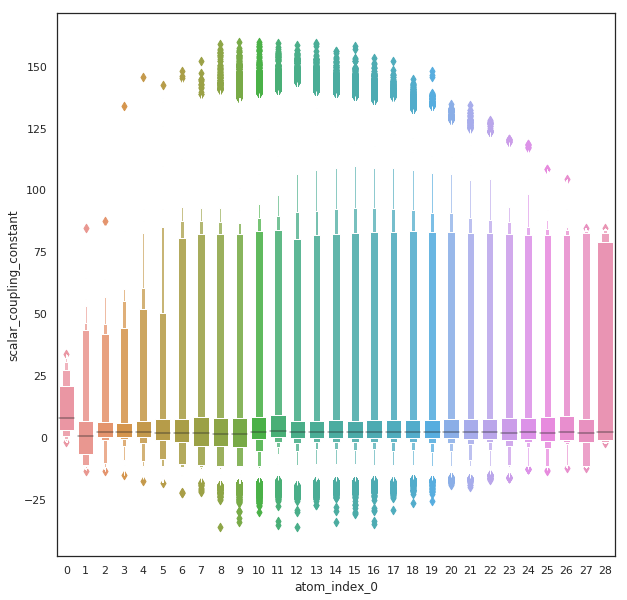

In [13]:
plt.figure(figsize=(10,10))
sbn.boxenplot(x='atom_index_0', y='scalar_coupling_constant', data=train_data)
plt.show()

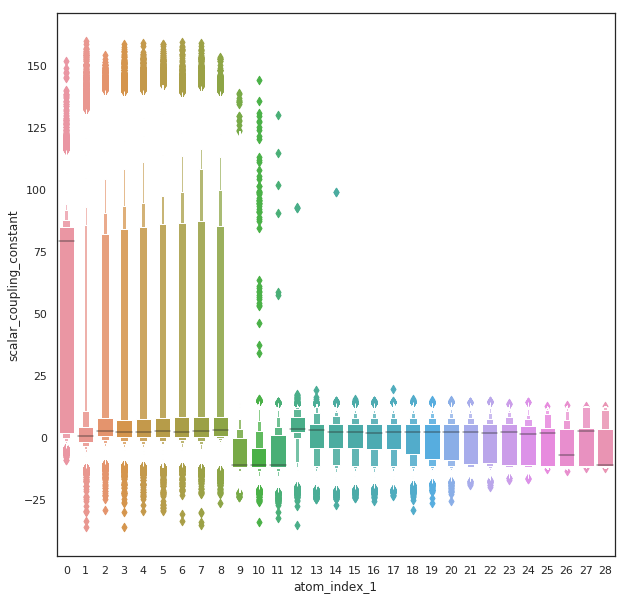

In [14]:
plt.figure(figsize=(10,10))
sbn.boxenplot(x='atom_index_1', y='scalar_coupling_constant', data=train_data)
plt.show()

In [15]:
scalar_index_cross = ['atom_index_0', 'atom_index_1']

cm = sbn.light_palette("green", as_cmap=True)
pd.crosstab(train_data[scalar_index_cross[0]], train_data[scalar_index_cross[1]], 
            values=train_data['scalar_coupling_constant'], aggfunc=['mean']).style.background_gradient(cmap = cm)

In [16]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structure_data, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train_data = map_atom_info(train_data, 0)
train_data = map_atom_info(train_data, 1)

test_data = map_atom_info(test_data, 0)
test_data = map_atom_info(test_data, 1)


In [17]:
train_data.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


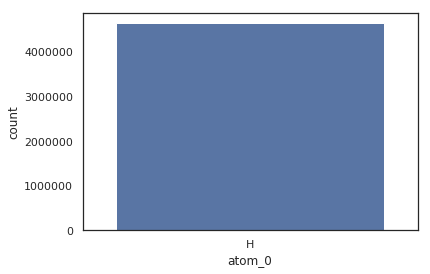

In [18]:
sbn.countplot(x='atom_0', data=train_data)

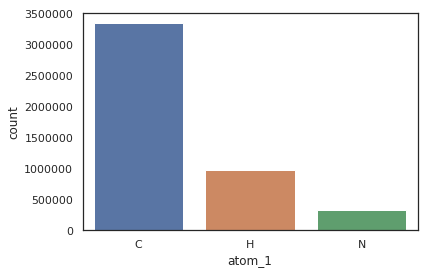

In [19]:
sbn.countplot(x='atom_1', data=train_data)

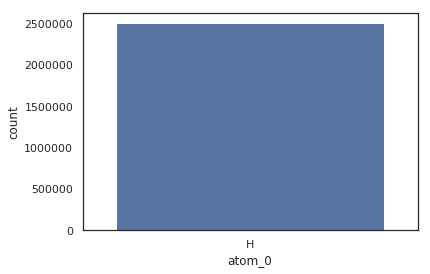

In [20]:
sbn.countplot(x='atom_0', data=test_data)

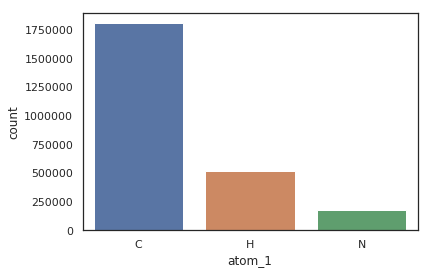

In [21]:
sbn.countplot(x='atom_1', data=test_data)

In [22]:
def calculate_distance(dataframe):
    dataframe['distance'] = ((dataframe['x_0']-dataframe['x_1'])**2 +
                             (dataframe['y_0']-dataframe['y_1'])**2 +
                             (dataframe['z_0']-dataframe['z_1'])**2)**0.5
    return dataframe

train_data = calculate_distance(train_data)
test_data = calculate_distance(test_data)

In [23]:
train_data.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952


In [24]:
def encode_data(train_data, test_data, attribute):
    label_encoder = LabelEncoder()
    train_data[attribute] = label_encoder.fit_transform(train_data[attribute].values)
    test_data[attribute] = label_encoder.transform(test_data[attribute].values)
    return train_data, test_data

train_data, test_data = encode_data(train_data, test_data, 'type')
train_data, test_data = encode_data(train_data, test_data, 'atom_0')
train_data, test_data = encode_data(train_data, test_data, 'atom_1')

molecules = train_data.pop('molecule_name')
test_data = test_data.drop('molecule_name', axis=1)
id_train = train_data.pop('id')
id_test = test_data.pop('id')

y = train_data.pop('scalar_coupling_constant')

In [25]:
train_data.head()

,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance
0,1,0,0,0,0.002150,-0.006031,0.001976,0,-0.012698,1.085804,0.008001,1.091953
1,1,2,3,0,0.002150,-0.006031,0.001976,1,1.011731,1.463751,0.000277,1.783120
2,1,3,3,0,0.002150,-0.006031,0.001976,1,-0.540815,1.447527,-0.876644,1.783147
3,1,4,3,0,0.002150,-0.006031,0.001976,1,-0.523814,1.437933,0.906397,1.783157
4,2,0,0,0,1.011731,1.463751,0.000277,0,-0.012698,1.085804,0.008001,1.091952


In [26]:
## Source: https://www.kaggle.com/abhishek/competition-metric
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type":train_data["type"]})
eval_df["scalar_coupling_constant"] = y

In [27]:
n_splits = 5 # Number of K-fold Splits

splits = list(GroupKFold(n_splits=n_splits).split(train_data, y, groups=molecules))

In [28]:
params = {"learning_rate" : 0.1,
          "depth": 9,
          'metric':'MAE',
          'min_samples_leaf': 3,
          "loss_function": "MAE"}


oof = np.zeros(len(train_data))
predictions = np.zeros(len(test_data))
feature_importance_df = pd.DataFrame()
features = [c for c in train_data.columns if c not in ['id']]

for i, (train_idx, valid_idx) in enumerate(splits):  
    print(f'Fold {i + 1}')
    x_train = np.array(train_data)
    y_train = np.array(y)
    trn_data = lgb.Dataset(x_train[train_idx.astype(int)], label=y_train[train_idx.astype(int)])
    val_data = lgb.Dataset(x_train[valid_idx.astype(int)], label=y_train[valid_idx.astype(int)])
    
    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    oof[valid_idx] = clf.predict(x_train[valid_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions += clf.predict(test_data, num_iteration=clf.best_iteration) / n_splits


Fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 2.25328	valid_1's l1: 2.25614
[1000]	training's l1: 2.16998	valid_1's l1: 2.18205
[1500]	training's l1: 2.11747	valid_1's l1: 2.13802
[2000]	training's l1: 2.07878	valid_1's l1: 2.10732
[2500]	training's l1: 2.04521	valid_1's l1: 2.08128
[3000]	training's l1: 2.01897	valid_1's l1: 2.06231
[3500]	training's l1: 1.99421	valid_1's l1: 2.04436
[4000]	training's l1: 1.97172	valid_1's l1: 2.0288
[4500]	training's l1: 1.95138	valid_1's l1: 2.01457
[5000]	training's l1: 1.93323	valid_1's l1: 2.00249
[5500]	training's l1: 1.9166	valid_1's l1: 1.99167
[6000]	training's l1: 1.90067	valid_1's l1: 1.9814
[6500]	training's l1: 1.88515	valid_1's l1: 1.97145
[7000]	training's l1: 1.87032	valid_1's l1: 1.96218
[7500]	training's l1: 1.85709	valid_1's l1: 1.95472
[8000]	training's l1: 1.84412	valid_1's l1: 1.94708
[8500]	training's l1: 1.83107	valid_1's l1: 1.93913
[9000]	training's l1: 1.81922	valid_1's l1: 1.9322

In [29]:
sample_submission = pd.read_csv('../input/sample_submission.csv')

benchmark = sample_submission.copy()
benchmark['scalar_coupling_constant'] = predictions
benchmark.to_csv('LGBM_submission.csv',index=False)